## 2.5 Sarsa 알고리즘 구현하기

In [70]:
# 구현에 사용할 패키지 임포트하기
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


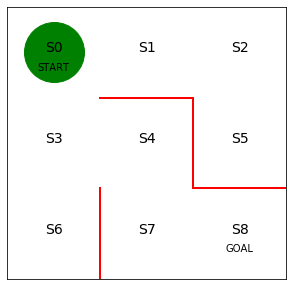

In [71]:
# 초기 상태의 미로 모습

# 전체 그림의 크기 및 그림을 나타내는 변수 선언
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 붉은 벽 그리기
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 상태를 의미하는 문자열(S0~S8) 표시
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 그림을 그릴 범위 및 눈금 제거 설정
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=False, right=False, left=False, labelleft=False)

# S0에 녹색 원으로 현재 위치를 표시
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)


# Random Policy 생성

In [72]:
# 정책을 결정하는 파라미터의 초깃값 theta_0를 설정

# 줄은 상태 0~7, 열은 행동방향(상,우,하,좌 순)를 나타낸다
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7、※s8은 목표지점이므로 정책이 없다
                    ])

In [73]:
# 정책 파라미터 theta_0을 무작위 행동 정책 pi로 변환하는 함수

def simple_convert_into_pi_from_theta(theta):
    '''단순 비율 계산'''

    [m, n] = theta.shape  # theta의 행렬 크기를 구함
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])  # 비율 계산

    pi = np.nan_to_num(pi)  # nan을 0으로 변환

    return pi

# 무작위 행동정책 pi_0을 계산
pi_0 = simple_convert_into_pi_from_theta(theta_0)

print("Initial Policy :\n", pi_0)

Initial Policy :
 [[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


# Initial Q-table 생성

In [74]:
# 행동가치 함수 Q의 초기 상태

[a, b] = theta_0.shape  # 열과 행의 갯수를 변수 a, b에 저장
Q = np.random.rand(a, b) * theta_0
# * theta0 로 요소 단위 곱셈을 수행, Q에서 벽 방향으로 이동하는 행동에는 nan을 부여

print("Initial Q-table is randomly created :\n", Q)

Initial Q-table is randomly created :
 [[       nan 0.46945124 0.57002848        nan]
 [       nan 0.07291225        nan 0.78837759]
 [       nan        nan 0.02975473 0.11721753]
 [0.45013277 0.57677352 0.87089504        nan]
 [       nan        nan 0.65805209 0.65432924]
 [0.51714996        nan        nan        nan]
 [0.4871742         nan        nan        nan]
 [0.88721221 0.31403595        nan        nan]]


# Function - get_action, get_s_next

In [75]:
# ε-greedy 알고리즘 구현


def get_action(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]

    # 행동을 결정
    if np.random.rand() < epsilon:
        # 확률 ε로 무작위 행동을 선택함
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # Q값이 최대가 되는 행동을 선택함
        next_direction = direction[np.nanargmax(Q[s, :])]

    # 행동을 인덱스로 변환
    if next_direction == "up":
        action = 0
    elif next_direction == "right":
        action = 1
    elif next_direction == "down":
        action = 2
    elif next_direction == "left":
        action = 3

    return action


def get_s_next(s, a):
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]  # 행동 a의 방향

    # 행동으로 다음 상태를 결정
    if next_direction == "up":
        s_next = s - 3  # 위로 이동하면 상태값이 3 줄어든다
    elif next_direction == "right":
        s_next = s + 1  # 오른쪽으로 이동하면 상태값이 1 늘어난다
    elif next_direction == "down":
        s_next = s + 3  # 아래로 이동하면 상태값이 3 늘어난다
    elif next_direction == "left":
        s_next = s - 1  # 왼쪽으로 이동하면 상태값이 1 줄어든다

    return s_next

# Q-table 업데이트 with Sarsa

In [76]:
# Sarsa 알고리즘으로 행동가치 함수 Q를 수정

def Sarsa(s, a, r, s_next, a_next, Q, eta, gamma):

    if s_next == 8:  # 목표 지점에 도달한 경우
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])

    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * Q[s_next, a_next] - Q[s, a])

    return Q


# 1 episode

In [77]:
# Sarsa 알고리즘으로 미로를 빠져나오는 함수, 상태 및 행동 그리고 Q값의 히스토리를 출력한다

def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi, episode):
    s = 0  # 시작 지점
    a = a_next = get_action(s, Q, epsilon, pi)  # 첫 번째 행동
    s_a_history = [[0, np.nan]]  # 에이전트의 행동 및 상태의 히스토리를 기록하는 리스트

    while (1):  # 목표 지점에 이를 때까지 반복
        a = a_next  # 행동 결정

        s_a_history[-1][1] = a
        # 현재 상태(마지막이므로 인덱스가 -1)을 히스토리에 추가

        s_next = get_s_next(s, a)
        # 다음 단계의 상태를 구함

        s_a_history.append([s_next, np.nan])
        # 다음 상태를 히스토리에 추가, 행동은 아직 알 수 없으므로 nan으로 둔다

        # 보상을 부여하고 다음 행동을 계산함
        if s_next == 8:
            r = 1  # 목표 지점에 도달했다면 보상을 부여
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
            # 다음 행동 a_next를 계산

        # 가치함수를 수정
        Q = Sarsa(s, a, r, s_next, a_next, Q, eta, gamma)
        if episode == 1:
            print("Q-table :\n", Q)
        
        # 종료 여부 판정
        if s_next == 8:  # 목표 지점에 도달하면 종료
            break
        else:
            s = s_next

    return [s_a_history, Q]

# Run N episode

In [78]:
# Sarsa 알고리즘으로 미로 빠져나오기

eta = 0.1  # 학습률
gamma = 0.9  # 시간할인율
epsilon = 0.5  # ε-greedy 알고리즘 epsilon 초깃값
v = np.nanmax(Q, axis=1)  # 각 상태마다 가치의 최댓값을 계산
episode = 1

for episode in range(1,51):
    print("에피소드: " + str(episode))

    # ε 값을 조금씩 감소시킴
    epsilon = epsilon / 2

    # Sarsa 알고리즘으로 미로를 빠져나온 후, 결과로 나온 행동 히스토리와 Q값을 변수에 저장
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0, episode)
    print("Q-table :\n", Q)

    # 상태가치의 변화
    new_v = np.nanmax(Q, axis=1)  # 각 상태마다 행동가치의 최댓값을 계산
    print(np.sum(np.abs(new_v - v)))  # 상태가치 함수의 변화를 출력
    v = new_v

    print("목표 지점에 이르기까지 걸린 단계 수는 " + str(len(s_a_history) - 1) + "단계입니다")


에피소드: 1
Q-table :
 [[       nan 0.4934601  0.57002848        nan]
 [       nan 0.07291225        nan 0.78837759]
 [       nan        nan 0.02975473 0.11721753]
 [0.45013277 0.57677352 0.87089504        nan]
 [       nan        nan 0.65805209 0.65432924]
 [0.51714996        nan        nan        nan]
 [0.4871742         nan        nan        nan]
 [0.88721221 0.31403595        nan        nan]]
Q-table :
 [[       nan 0.4934601  0.57002848        nan]
 [       nan 0.07291225        nan 0.76084239]
 [       nan        nan 0.02975473 0.11721753]
 [0.45013277 0.57677352 0.87089504        nan]
 [       nan        nan 0.65805209 0.65432924]
 [0.51714996        nan        nan        nan]
 [0.4871742         nan        nan        nan]
 [0.88721221 0.31403595        nan        nan]]
Q-table :
 [[       nan 0.4934601  0.59140618        nan]
 [       nan 0.07291225        nan 0.76084239]
 [       nan        nan 0.02975473 0.11721753]
 [0.45013277 0.57677352 0.87089504        nan]
 [       nan     